Numerical Experiment, script 3 of the whole program, Chi Zhang  
-- Calculate credit risk premium 3m LIBOR- 3m SOFR, liquidity risk premium EFFR – inflation;  
-- Regress swap spd on the two risk factors for each tenor;  
-- Simulate the residual as O-U process for each tenor;  
-- Recover the simlulated swap spd curve;  
-- Run multi-stage forecasting framework for swap spd curve from script 2;

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding

## Cleaned data loading (till 2021-03-12)

In [2]:
LIBOR_zero = pd.read_excel(r'Data\LIBOR_clean.xlsx', index_col = 0, sheet_name='zero')

In [3]:
SOFR_zero = pd.read_excel(r'Data\SOFR_clean.xlsx', index_col = 0, sheet_name='zero')

In [4]:
Treasury_zero = pd.read_excel(r'Data\Treasury_clean.xlsx', index_col = 0, sheet_name='zero')

In [5]:
OIS_zero = pd.read_excel(r'Data\OIS_clean.xlsx', index_col = 0, sheet_name='zero')

inflation rate load, clean, resample

In [6]:
Infl_daily = pd.read_excel(r'Data\inflation_daily.xlsx', index_col = 0, sheet_name = 'Sheet1')

In [7]:
Infl_daily = Infl_daily.rename(columns={'Last Price':'Inflation'})
Infl_daily.index = pd.to_datetime(Infl_daily.index, infer_datetime_format=True)
Infl_daily = Infl_daily.sort_values(by='Date')
Infl_daily = Infl_daily.reindex(pd.date_range(start='11/02/2018', end='3/12/2021', freq='D'), method='ffill')

In [8]:
Infl_weekly = Infl_daily.loc[LIBOR_zero.index]

FFR load, clean, resample

In [9]:
FFR_daily = pd.read_excel(r'Data\FFR_daily.xlsx', index_col = 0, sheet_name = 'Sheet1')

In [10]:
FFR_daily = FFR_daily.rename(columns={'PX_LAST':'FFR'})
FFR_daily.index = pd.to_datetime(FFR_daily.index, infer_datetime_format=True)
FFR_daily = FFR_daily.sort_values(by='Date')
FFR_daily = FFR_daily.reindex(pd.date_range(start='11/02/2018', end='3/12/2021', freq='D'), method='ffill')

In [11]:
FFR_weekly = FFR_daily.loc[LIBOR_zero.index]

## Spread and premium(s) calculation

In [12]:
SwapSpd_zero = LIBOR_zero - Treasury_zero
risk_prem = LIBOR_zero[3] - SOFR_zero[3]
lqd_prem = FFR_weekly['FFR'] - Infl_weekly['Inflation']
prems = pd.DataFrame({'risk_prem': risk_prem, 'lqd_prem': lqd_prem })
scaler = StandardScaler()
scaler.fit(prems)
prems_scaled = pd.DataFrame(scaler.transform(prems),index=prems.index,columns=prems.columns)

,risk_prem,lqd_prem
risk_prem,1.000000,0.393446
lqd_prem,0.393446,1.000000


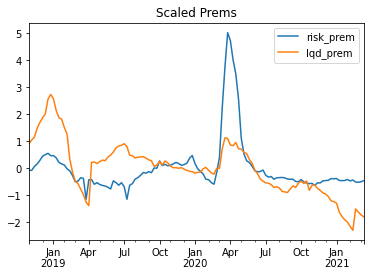

In [13]:
prems_scaled.plot()
plt.title('Scaled Prems')
prems_scaled.corr()

In [14]:
SwapSpd_zero = SwapSpd_zero[[tenor for tenor in SwapSpd_zero.columns if tenor%12 == 0]]
SwapSpd_zero.columns

Int64Index([  0,  12,  24,  36,  48,  60,  72,  84,  96, 108, 120, 132, 144,
            156, 168, 180, 192, 204, 216, 228, 240, 252, 264, 276, 288, 300,
            312, 324, 336, 348],
           dtype='int64')

## Regression to get residual series for each tenor

In [15]:
reg_prem = LinearRegression(fit_intercept=True, normalize=False).fit(prems_scaled, SwapSpd_zero) # include constant intercept, no normalization since we have done standarization before

In [16]:
reg_prem.coef_.shape

(30, 2)

In [17]:
reg_prem.intercept_.shape

(30,)

In [18]:
Resid = SwapSpd_zero - reg_prem.predict(prems_scaled)
print(Resid.shape)

(124, 30)


In [19]:
np.mean(np.std(Resid))

0.0847340212241746

Text(0.5, 1.0, 'residual from OLS regression for each tenor')

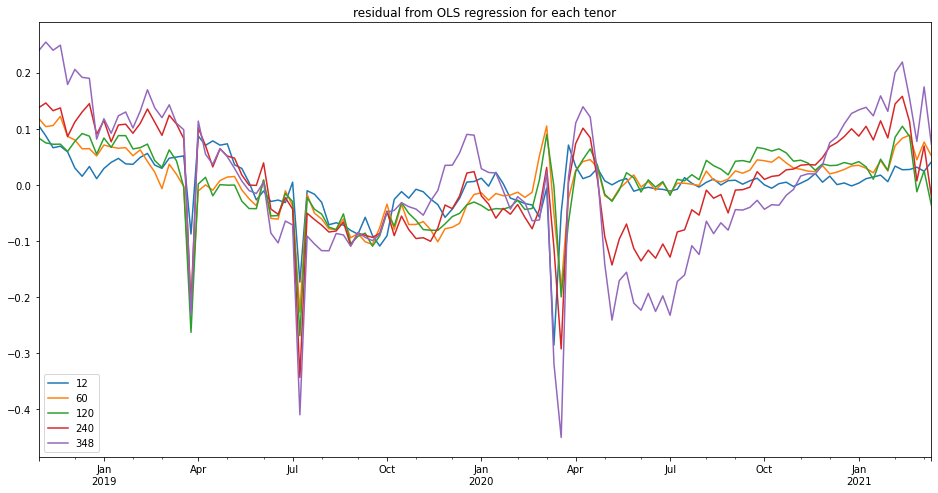

In [20]:
Resid[[12,60,120,240,348]].plot(figsize=(16,8))
plt.title('residual from OLS regression for each tenor')

## Test and Simulation of residual series for each tenor

ADF test: null hypo: unit root and random walk; A small P-value will help us reject the null hypo, so the time series is stationary.

In [21]:
from statsmodels.tsa.stattools import adfuller

In [24]:
for tenor in [12,24,36,60,84,120,180,240,300,348]:
    print(tenor,'month:',round(adfuller(Resid[tenor],regression='nc')[1], 3))

12 month: 0.002
24 month: 0.013
36 month: 0.005
60 month: 0.042
84 month: 0.013
120 month: 0.076
180 month: 0.009
240 month: 0.003
300 month: 0.004
348 month: 0.003


In [27]:
SwapSpd_zero.index[60:]

DatetimeIndex(['2019-12-27', '2020-01-03', '2020-01-10', '2020-01-17',
               '2020-01-24', '2020-01-31', '2020-02-07', '2020-02-14',
               '2020-02-21', '2020-02-28', '2020-03-06', '2020-03-13',
               '2020-03-20', '2020-03-27', '2020-04-03', '2020-04-10',
               '2020-04-17', '2020-04-24', '2020-05-01', '2020-05-08',
               '2020-05-15', '2020-05-22', '2020-05-29', '2020-06-05',
               '2020-06-12', '2020-06-19', '2020-06-26', '2020-07-03',
               '2020-07-10', '2020-07-17', '2020-07-24', '2020-07-31',
               '2020-08-07', '2020-08-14', '2020-08-21', '2020-08-28',
               '2020-09-04', '2020-09-11', '2020-09-18', '2020-09-25',
               '2020-10-02', '2020-10-09', '2020-10-16', '2020-10-23',
               '2020-10-30', '2020-11-06', '2020-11-13', '2020-11-20',
               '2020-11-27', '2020-12-04', '2020-12-11', '2020-12-18',
               '2020-12-25', '2021-01-01', '2021-01-08', '2021-01-15',
      

O-U process estimation

\begin{aligned}
\mathbf dS_{t} &= \mathbf \lambda (\mu - S_t)F_k d_t + \mathbf \sigma dW_t
\end{aligned}

In [31]:
delta = 1/52
OU_df = pd.DataFrame(columns=Resid.columns, index = ['lamda', 'mu', 'sig']) # col name is tenor, each row is lamda or mu or sig
for tenor in SwapSpd_zero.columns:
    reg = LinearRegression(fit_intercept=True, normalize=False).fit(Resid[:-1][tenor].values.reshape(-1,1), Resid[1:][tenor].values.reshape(-1,1))
    a = reg.coef_[0,0]
    b = reg.intercept_[0]
    epsilon = Resid[1:][tenor].values.reshape(-1,1) - reg.predict(Resid[:-1][tenor].values.reshape(-1,1))
    
    OU_df.loc['lamda', tenor] = -np.log(a)/delta
    OU_df.loc['mu', tenor] = b/(1-a)
    OU_df.loc['sig', tenor] = np.std(epsilon) * np.sqrt(-2*np.log(a)/(delta*(1-a**2)))

In [32]:
OU_df

,0,12,24,36,48,60,72,84,96,108,...,240,252,264,276,288,300,312,324,336,348
lamda,31.3382,34.913,17.8904,19.1617,20.6341,21.8159,22.8882,22.9537,23.9708,24.9631,...,19.3523,18.1693,17.0654,16.1166,15.3595,14.8068,14.4467,14.2418,14.1559,14.1606
mu,-0.00901423,-0.00141203,-0.00280194,-0.00285013,-0.00231017,-0.00200274,-0.00190408,-0.00201191,-0.00209187,-0.00216306,...,-0.00396625,-0.00431378,-0.00467538,-0.00502886,-0.00535455,-0.00563287,-0.00585526,-0.0060273,-0.0061582,-0.00625842
sig,0.963716,0.407482,0.346925,0.347188,0.367087,0.392162,0.412413,0.419477,0.436175,0.451551,...,0.564783,0.573277,0.581483,0.59052,0.601199,0.614072,0.629371,0.646681,0.665601,0.68584


Text(0.5, 1.0, 'estimated params of OU process for each tenor')

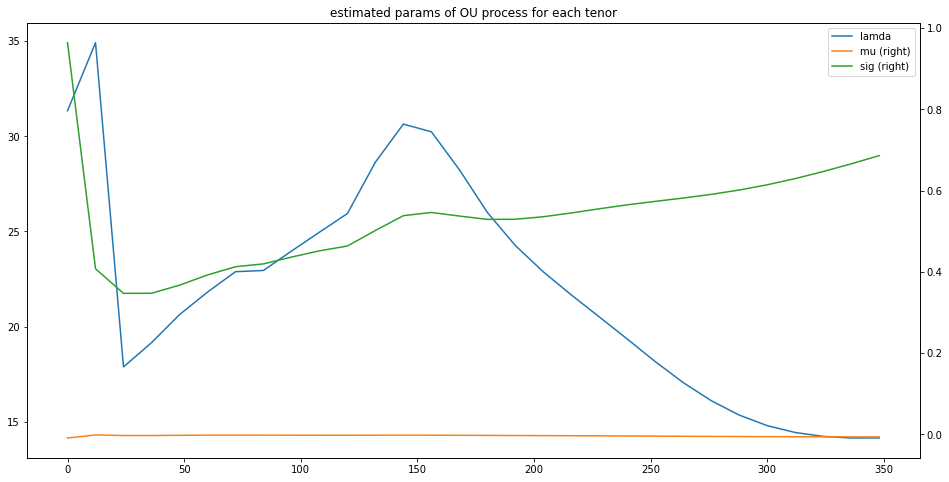

In [33]:
OU_df.T.plot(figsize=(16,8), secondary_y = ['mu','sig'])
plt.title('estimated params of OU process for each tenor')

O-U process simulation

In [34]:
# params for simulation
num_paths = int(1e3)

In [35]:
np.random.seed(210628)
shocks = np.random.randn(num_paths, Resid.shape[0]-1)
print(shocks.shape)

(1000, 123)


In [36]:
# first time step
Resid_simu = np.zeros(shape = (shocks.shape[0], shocks.shape[1], OU_df.shape[1]))
Resid_simu[:,0,:] = np.array(Resid.iloc[0]) * np.exp(-np.array(OU_df.loc['lamda']).astype(float)*delta) \
                    + np.array(OU_df.loc['mu']) * (1 - np.exp(-np.array(OU_df.loc['lamda']).astype(float)*delta)) \
                    + np.dot(shocks[:,0:1], (np.array(OU_df.loc['sig']) * np.sqrt((1-np.exp(-2*np.array(OU_df.loc['lamda']).astype(float)*delta))/(2*np.array(OU_df.loc['lamda']).astype(float)))).reshape(1,-1))

In [37]:
# remaining time steps
for t in range(1, Resid_simu.shape[1]):
    Resid_simu[:,t,:] = np.multiply(Resid_simu[:,t-1,:], np.exp(-np.array(OU_df.loc['lamda']).astype(float)*delta)) \
                    + np.array(OU_df.loc['mu']) * (1 - np.exp(-np.array(OU_df.loc['lamda']).astype(float)*delta)) \
                    + np.dot(shocks[:,t:t+1], (np.array(OU_df.loc['sig']) * np.sqrt((1-np.exp(-2*np.array(OU_df.loc['lamda']).astype(float)*delta))/(2*np.array(OU_df.loc['lamda']).astype(float)))).reshape(1,-1))

## Recover the simlulated swap spd curve from the residual factor and two prems

In [38]:
Resid_simu.shape

(1000, 123, 30)

In [39]:
np.repeat(np.array(Resid.iloc[0]).reshape(1,-1)[np.newaxis,:,:], 1000, axis=0).shape

(1000, 1, 30)

In [40]:
SwapSpd_simu = np.concatenate((np.repeat(np.array(Resid.iloc[0]).reshape(1,-1)[np.newaxis,:,:], 1000, axis=0), Resid_simu), axis=1)

In [41]:
SwapSpd_simu = np.repeat(reg_prem.predict(prems_scaled)[np.newaxis,:,:], 1000, axis=0) + SwapSpd_simu
print(SwapSpd_simu.shape)

(1000, 124, 30)


## Reconstruction to high-D and real-time backtesting (from script 2)

In real-time backtesting, we implemented the PCA-based and LLE-based engine:  
(1) get low-dim representations  
(2) for each factor, calibrate the newest Kalman beta, then do one-step ahead prediction  
(3) inverse transform the predicted factors back to original space  
(4) evaluate out-of-sample accuracy for tenors of our interest  
(5) design systematic trading strategies according to the outputed signals.

Trading instrument details: long/short a float-leg receiver swap (remaining T = 5yr (260wk), N = 100M, semiannually coupon payment (every 26wk), float-rate is the X-month spread, fixed-rate is 1%), holding period = 1 wk)  

Note: 1yr = 12month, 1month = 4.3333wk

In [2]:
import statsmodels.tsa.statespace.sarimax as smss
import warnings
warnings.filterwarnings('ignore')

### PCA-based

In [37]:
# for one sample scenario
def Backtesting_PCA(curve_data, rolling_window=60, N=100, swap_rate=1.00, T=260):
    accry = {12:0, 24:0, 36:0, 60:0, 84:0, 120:0, 180:0, 240:0, 300:0, 348:0}
    PnL = pd.DataFrame(columns=list(accry.keys()), index = curve_data[rolling_window+1:].index)
    prices = pd.DataFrame(columns=list(accry.keys()), index = curve_data[rolling_window:].index)
    T_rmn = T
    
    # calculate init price
    for m in list(accry.keys()):
        # the fixed-leg value is
        fix_val = np.sum(0.5*swap_rate/100*N* \
                  np.exp(- OIS_zero.loc[curve_data[rolling_window:rolling_window+1].index].values[0,2:21:2]/100 * curve_data[rolling_window:rolling_window+1].columns[2:21:2] / 12))+ \
                  N*np.exp(- OIS_zero.loc[curve_data[rolling_window:rolling_window+1].index].values[0,20]/100 * curve_data[rolling_window:rolling_window+1].columns[20] / 12)
        # the float-leg value is
        float_val = (1+0.5*curve_data[rolling_window:rolling_window+1][m].values[0]/100)*N* \
                    np.exp(- OIS_zero.loc[curve_data[rolling_window:rolling_window+1].index].values[0,2]/100 * curve_data[rolling_window:rolling_window+1].columns[2] / 12)
        
        prices.loc[curve_data[rolling_window:rolling_window+1].index, m] = float_val-fix_val
    
    for i in range( rolling_window, curve_data.shape[0]-1):
        
        # curve_data[i].index is the time to make decision, curve_data[i+1] is the time to materialize PnL
        # the first i = rolling_window
        
        train_data = curve_data[i-rolling_window:i+1]
        test_data = curve_data[i+1:i+2]
    
        scaler = StandardScaler()
        scaler.fit(train_data)
        train_data_scaled = scaler.transform(train_data)
    
        model1 = PCA(n_components=3, copy=True, whiten=False)
        model1.fit(train_data_scaled)
        train_data_low = pd.DataFrame(model1.transform(train_data_scaled))
        train_data_low.index = train_data.index
    
    
        pred_lst = []
        for col in train_data_low.columns:
#             # Training:
#             # init a KF instantiate
#             KR = KF.Kalman_regression(train_data_low[col][:-1], train_data_low[col][1:])
#             # calibrate the noise params using MLE
#             KR.calibrate_MLE()
        
#             # run the exact Kalman Algo
#             KR.run()
    
#             KR.beta0 = KR.betas[-1]
#             KR.P0 = KR.Ps[-1]
    
#             # Predict:
#             pred = KR.beta0 * train_data_low[col][-1] + KR.alpha0
#             pred_lst.append(pred)
    
            ARMA11 = smss.SARIMAX( train_data_low[col], order=(1,0,1) )
            res_fit = ARMA11.fit(disp=0,method='lbfgs')
            pred_lst.append(res_fit.forecast(1).values[0])
            
        pred_ary = np.array(pred_lst).reshape(1,-1)
        pred_data = model1.inverse_transform(pred_ary)
        pred_data = scaler.inverse_transform(pred_data)
        
        
        T_rmn -= 1 # one more less remaining week time to maturity
        # evaluate
        for m in list(accry.keys()):
            if (test_data[m].values-train_data[-1:][m].values) * (pred_data[0,int(m/12)]-train_data[-1:][m].values) >= 0:
                accry[m] += 1    # if underlying float-rate is m-month:
            # match the best approximate discount factor and coupon payment date
            num_rmn_payment = int(np.ceil(T_rmn/(4.3333*6)))
            max_payment_month = int(np.ceil(T_rmn/(4.3333*3)))
            payment_wks = np.arange(T_rmn-26*(num_rmn_payment-1), T_rmn+1, 26)
            assert num_rmn_payment==payment_wks.size
            
             
            # the fixed-leg value is
            fix_val = np.sum(0.5*swap_rate/100*N* \
                      np.exp(- OIS_zero.loc[test_data.index].values[0,max_payment_month-2*num_rmn_payment+2:max_payment_month+1:2]/100 * payment_wks / 52))+ \
                      N*np.exp(- OIS_zero.loc[test_data.index].values[0,max_payment_month]/100 * payment_wks[-1] / 52)
            # the float-leg value is
            float_val = (1+0.5*test_data[m].values[0]/100)*N* \
                        np.exp(- OIS_zero.loc[test_data.index].values[0,max_payment_month-2*num_rmn_payment+2]/100 * payment_wks[0] / 52)
         
            # update new swap price
            prices.loc[test_data.index, m] = float_val-fix_val
            
            if pred_data[0,int(m/12)]-train_data[-1:][m].values >= 0:
                PnL.loc[test_data.index, m] = prices.diff().loc[test_data.index, m]
            else:
                PnL.loc[test_data.index, m] = - prices.diff().loc[test_data.index, m]
        
        #print(test_data.columns[max_payment_month-2*num_rmn_payment+2:max_payment_month+1:2])
        #print(payment_wks)
                
    
    accry = {key: round(value / (curve_data.shape[0]-1 - rolling_window),3) for key, value in accry.items()}

    
    return accry, PnL, prices

For swap spread (original scenario)

In [38]:
res_SwapSpd, PnL_SwapSpd, prices_SwapSpd = Backtesting_PCA(SwapSpd_zero, rolling_window=60)

In [39]:
res_SwapSpd # one-step forecasting accuracy

{12: 0.571,
 24: 0.587,
 36: 0.54,
 60: 0.571,
 84: 0.556,
 120: 0.587,
 180: 0.492,
 240: 0.413,
 300: 0.413,
 348: 0.492}

<AxesSubplot:>

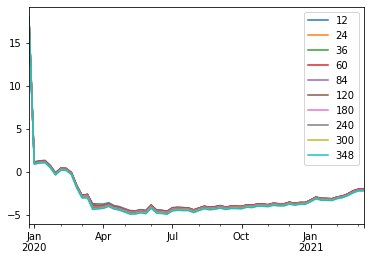

In [40]:
prices_SwapSpd.plot() # price time series with different tenors of spread as underlying

12     17.1883
24     14.2272
36     13.0688
60     16.3655
84      17.292
120    10.2755
180    10.9628
240    12.1819
300    12.3898
348    12.1987
Name: 2021-03-12 00:00:00, dtype: object

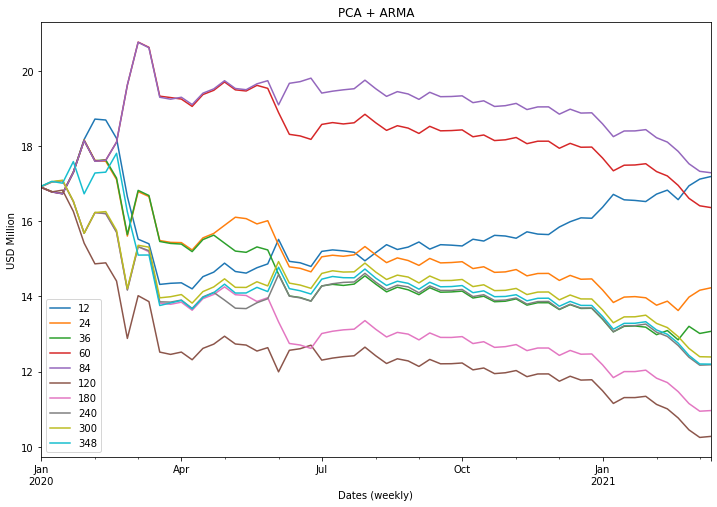

In [41]:
PnL_SwapSpd.cumsum().plot(figsize = (12,8)) # Culmulative PnL with different tenors of spread as underlying
plt.xlabel("Dates (weekly)")
plt.ylabel("USD Million")
plt.title("PCA + ARMA")
PnL_SwapSpd.cumsum().iloc[-1]

12     0.272831
24     0.225829
36     0.207442
60     0.259770
84     0.274477
120    0.163103
180    0.174013
240    0.193363
300    0.196664
348    0.193630
dtype: float64 
 12     2.161856
24     2.167893
36     2.169743
60     2.164417
84     2.162682
120    2.174759
180    2.175201
240    2.174597
300    2.175099
348    2.175982
dtype: float64


Text(0.5, 1.0, 'PnL Comparison for SwapSpd (Blue: PCA+ARMA; Red: LLE+ARMA)')

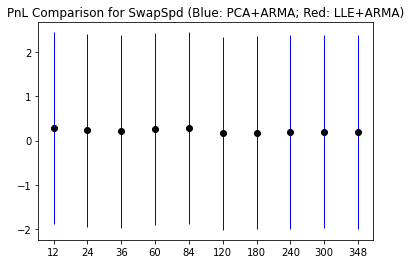

In [42]:
# mean and std of absolute returns
print(PnL_SwapSpd.mean(),'\n', PnL_SwapSpd.std())
f_swap, ax_swap = plt.subplots(1)
ax_swap.errorbar(np.arange(len(PnL_SwapSpd.columns)), PnL_SwapSpd.mean(), PnL_SwapSpd.std(), fmt='ok', lw=1, ecolor = 'b')
plt.xticks(np.arange(len(PnL_SwapSpd.columns)), PnL_SwapSpd.columns)
plt.title('PnL Comparison for SwapSpd (Blue: PCA+ARMA; Red: LLE+ARMA)')

The accuracy of directly modeling spread curves are much higher than modeling the three original curves respectively.  
- For the swap spread zero curve, except the 20yr and 30yr tenor, the out-of-sample accuracy for all other tenors are larger than 0.5.  

### LLE-based

Because the (inverse) manifold learning algo is not a injective function for nonlinear DR (at least for MDS), we may cannot come up with a general approach. Three potential solutions: (1) nonparametric regression, by Z. Zhang and H. Zha, “Principal manifolds and nonlinear dimension reduction via tangent space alignment,”; (2) inverse manifold learning (encoding and decoding) by the scholars in Xihu University (2020). (3) simple LLE reconstruction, by Jin Chen, Shijie Deng, and Xiaoming Huo (2004).

In [3]:
def barycenter_weights(X, Z, reg=1e-3):
    """Compute barycenter weights of X from Z along the first axis
    We estimate the weights to assign to each point in Z[i] to recover
    the point X[i]. The barycenter weights sum to 1.
    Parameters
    ----------
    X : array-like, shape (n_samples, n_dim), original data matrix need to approximate
    Z : array-like, shape (n_samples, n_neighbors, n_dim), neighbor data matrix provided
    reg : float, optional
        amount of regularization to add for the problem to be
        well-posed in the case of n_neighbors > n_dim
    Returns
    -------
    B : array-like, shape (n_samples, n_neighbors), weights matrix
    """
    n_samples, n_neighbors = X.shape[0], Z.shape[1]
    B = np.empty((n_samples, n_neighbors), dtype=X.dtype)
    v = np.ones(n_neighbors, dtype=X.dtype)

    # this might raise a LinalgError if G is singular and has trace zero
    for i, A in enumerate(Z.transpose(0, 2, 1)): # the transposed matrix will be in (n_samples by n_dim by n_neighb)
        # i is the sample index, A is the n_dim by n_neighb matrix
        C = A.T - X[i]  # broadcasting: (n_neighb by n_dim) - (1 by n_dim)
        G = np.dot(C, C.T) # Gram matrix in n_neighb by n_neighb
        trace = np.trace(G)
        if trace > 0:
            R = reg * trace
        else:
            R = reg
        # add regularization term to diagonal of G
        G.flat[::Z.shape[1] + 1] += R
        # solve linear system of equations Gw=v
        w = solve(G, v, sym_pos=True) # n_neighb by 1
        # rescale weights
        B[i, :] = w / np.sum(w)
    return B

In [4]:
from scipy.linalg import eigh, svd, qr, solve
from scipy.sparse import eye, csr_matrix, find
from scipy.sparse.linalg import eigsh
from sklearn.neighbors import NearestNeighbors

def barycenter_kneighbors_graph(X, n_neighbors, reg=1e-3, n_jobs=None):
    """Computes the barycenter weighted graph of k-Neighbors for points in X
    Parameters
    ----------
    X : {array-like, NearestNeighbors}
        Sample data, shape = (n_samples, n_features), in the form of a
        numpy array or a NearestNeighbors object.
    n_neighbors : int
        Number of neighbors for each sample.
    reg : float, optional
        Amount of regularization when solving the least-squares
        problem. Only relevant if mode='barycenter'. If None, use the
        default.
    n_jobs : int or None, optional (default=None)
        The number of parallel jobs to run for neighbors search.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.
    Returns
    -------
    A : sparse matrix in CSR format, shape = [n_samples, n_samples]
        A[i, j] is assigned the weight of edge that connects i to j.
    See also
    --------
    sklearn.neighbors.kneighbors_graph
    sklearn.neighbors.radius_neighbors_graph
    """
    knn = NearestNeighbors(n_neighbors + 1, n_jobs=n_jobs).fit(X)
    X = knn._fit_X
    n_samples = X.shape[0]
    ind = knn.kneighbors(X, return_distance=False)[:, 1:] #(n_samples by n_neighb)
    
    data = barycenter_weights(X, X[ind], reg=reg)
    # call the func to compute weights (n_samples by n_neighb)
    
    indptr = np.arange(0, n_samples * n_neighbors + 1, n_neighbors)
    return csr_matrix((data.ravel(), ind.ravel(), indptr),
                      shape=(n_samples, n_samples))

In [45]:
def Backtesting_LLE(curve_data, rolling_window=60, N=100, swap_rate=1.00, T=260, num_neighbors = 37):
    accry = {12:0, 24:0, 36:0, 60:0, 84:0, 120:0, 180:0, 240:0, 300:0, 348:0}
    PnL = pd.DataFrame(columns=list(accry.keys()), index = curve_data[rolling_window+1:].index)
    prices = pd.DataFrame(columns=list(accry.keys()), index = curve_data[rolling_window:].index)
    T_rmn = T
    
    # calculate init price
    for m in list(accry.keys()):
        # the fixed-leg value is
        fix_val = np.sum(0.5*swap_rate/100*N* \
                  np.exp(- OIS_zero.loc[curve_data[rolling_window:rolling_window+1].index].values[0,2:21:2]/100 * curve_data[rolling_window:rolling_window+1].columns[2:21:2] / 12))+ \
                  N*np.exp(- OIS_zero.loc[curve_data[rolling_window:rolling_window+1].index].values[0,20]/100 * curve_data[rolling_window:rolling_window+1].columns[20] / 12)
        # the float-leg value is
        float_val = (1+0.5*curve_data[rolling_window:rolling_window+1][m].values[0]/100)*N* \
                    np.exp(- OIS_zero.loc[curve_data[rolling_window:rolling_window+1].index].values[0,2]/100 * curve_data[rolling_window:rolling_window+1].columns[2] / 12)
        
        prices.loc[curve_data[rolling_window:rolling_window+1].index, m] = float_val-fix_val
    
    
    for i in range( rolling_window, curve_data.shape[0]-1):
    
        train_data = curve_data[i-rolling_window:i+1]
        test_data = curve_data[i+1:i+2]
    
        scaler = StandardScaler()
        scaler.fit(train_data)
        train_data_scaled = scaler.transform(train_data)
    
        model2 = LocallyLinearEmbedding(n_components=3, n_neighbors=num_neighbors)
        model2.fit(train_data_scaled)
        train_data_low = pd.DataFrame(model2.transform(train_data_scaled))
        train_data_low.index = train_data.index
        
    
        pred_lst = []
        for col in train_data_low.columns:
#             # Training:
#             # init a KF instantiate
#             KR = KF.Kalman_regression(train_data_low[col][:-1], train_data_low[col][1:])
#             # calibrate the noise params using MLE
#             KR.calibrate_MLE()
        
#             # run the exact Kalman Algo
#             KR.run()
    
#             KR.beta0 = KR.betas[-1]
#             KR.P0 = KR.Ps[-1]
    
#             # Predict:
#             pred = KR.beta0 * train_data_low[col][-1] + KR.alpha0
#             pred_lst.append(pred)
            
            ARMA11 = smss.SARIMAX( train_data_low[col], order=(1,0,1) )
            res_fit = ARMA11.fit(disp=0,method='lbfgs')
            pred_lst.append(res_fit.forecast(1).values[0])
    
    
        pred_ary = np.array(pred_lst).reshape(1,-1)
        
        # inverse transform
        X = np.vstack((train_data_low.to_numpy(),pred_ary))
        
        W = barycenter_kneighbors_graph(X, n_neighbors=num_neighbors)
        pred_data = W.toarray()[-1:,:-1].dot(train_data_scaled) # (1 by n_samples-1) times (n_train_samples by high_dim)
        #print(pred_data.shape, type(pred_data))
        
        pred_data = scaler.inverse_transform(pred_data)

        T_rmn -= 1 # one more less remaining week time to maturity
        # evaluate
        for m in list(accry.keys()):
            if (test_data[m].values-train_data[-1:][m].values) * (pred_data[0,int(m/12)]-train_data[-1:][m].values) >= 0:
                accry[m] += 1    # if underlying float-rate is m-month:
            # match the best approximate discount factor and coupon payment date
            num_rmn_payment = int(np.ceil(T_rmn/(4.3333*6)))
            max_payment_month = int(np.ceil(T_rmn/(4.3333*3)))
            payment_wks = np.arange(T_rmn-26*(num_rmn_payment-1), T_rmn+1, 26)
            assert num_rmn_payment==payment_wks.size
            
             
            # the fixed-leg value is
            fix_val = np.sum(0.5*swap_rate/100*N* \
                      np.exp(- OIS_zero.loc[test_data.index].values[0,max_payment_month-2*num_rmn_payment+2:max_payment_month+1:2]/100 * payment_wks / 52))+ \
                      N*np.exp(- OIS_zero.loc[test_data.index].values[0,max_payment_month]/100 * payment_wks[-1] / 52)
            # the float-leg value is
            float_val = (1+0.5*test_data[m].values[0]/100)*N* \
                        np.exp(- OIS_zero.loc[test_data.index].values[0,max_payment_month-2*num_rmn_payment+2]/100 * payment_wks[0] / 52)
         
            # update new swap price
            prices.loc[test_data.index, m] = float_val-fix_val
            
            if pred_data[0,int(m/12)]-train_data[-1:][m].values >= 0:
                PnL.loc[test_data.index, m] = prices.diff().loc[test_data.index, m]
            else:
                PnL.loc[test_data.index, m] = - prices.diff().loc[test_data.index, m]
    
    accry = {key: round(value / (curve_data.shape[0]-1 - rolling_window),3) for key, value in accry.items()}

    
    return accry, PnL, prices

For swap spread

In [46]:
res_SwapSpd, PnL_SwapSpd, prices_SwapSpd = Backtesting_LLE(SwapSpd_zero, rolling_window=60)
res_SwapSpd

{12: 0.667,
 24: 0.571,
 36: 0.556,
 60: 0.571,
 84: 0.54,
 120: 0.571,
 180: 0.508,
 240: 0.476,
 300: 0.413,
 348: 0.46}

12     16.2948
24     14.4511
36     11.9356
60     17.3283
84     17.1887
120     10.525
180    10.4169
240    10.5576
300    12.6799
348      11.29
Name: 2021-03-12 00:00:00, dtype: object

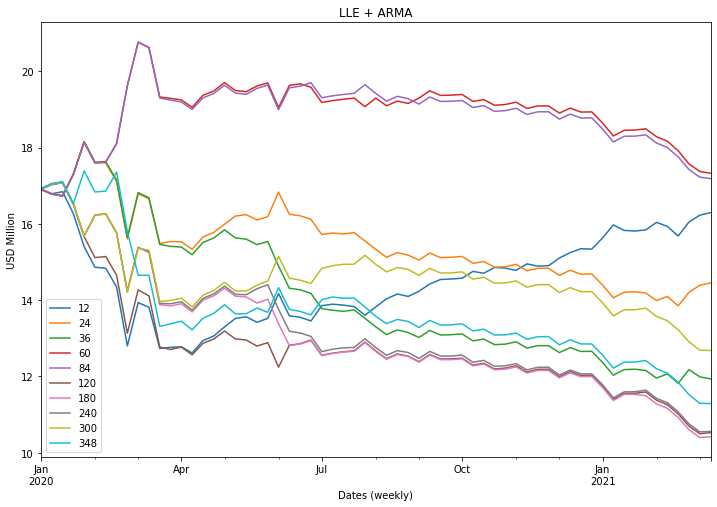

In [47]:
PnL_SwapSpd.cumsum().plot(figsize=(12,8))
plt.xlabel("Dates (weekly)")
plt.ylabel("USD Million")
plt.title("LLE + ARMA")
PnL_SwapSpd.cumsum().iloc[-1]

12     0.258648
24     0.229383
36     0.189454
60     0.275052
84     0.272836
120    0.167064
180    0.165348
240    0.167581
300    0.201269
348    0.179206
dtype: float64 
 12     2.163626
24     2.167514
36     2.171414
60     2.162497
84     2.162893
120    2.174454
180    2.175888
240    2.176770
300    2.174671
348    2.177238
dtype: float64


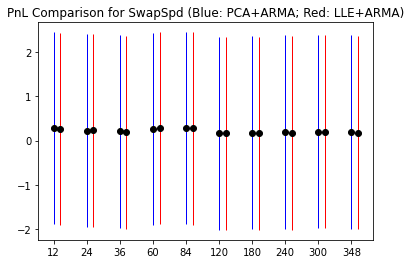

In [48]:
# mean and std of absolute returns
print(PnL_SwapSpd.mean(),'\n', PnL_SwapSpd.std())
ax_swap.errorbar(np.arange(0.2, len(PnL_SwapSpd.columns)+0.2), PnL_SwapSpd.mean(), PnL_SwapSpd.std(), fmt='ok', lw=1, ecolor = 'r')
f_swap

- For the swap spread zero curve, except the 20yr tenor, the out-of-sample accuracy for all other tenors are larger than 0.5.  

### Hyper-parameters selection: num_neighbors

In [55]:
rec_error = np.zeros((100,48))
for i in range(100):
    # fetch one simulated scenario
    input_curve = pd.DataFrame(SwapSpd_simu[i], index = SwapSpd_zero.index, columns = SwapSpd_zero.columns)

    scaler = StandardScaler()
    scaler.fit(input_curve)
    train_data_scaled = scaler.transform(input_curve)

    for j in range(3,51,1):
        model_cali = LocallyLinearEmbedding(n_components=3, n_neighbors=j, method='standard')
        model_cali.fit(train_data_scaled)
        train_data_low = pd.DataFrame(model_cali.transform(train_data_scaled))
        train_data_low.index = input_curve.index
        # inverse transform
        X = train_data_low.to_numpy()
        W = barycenter_kneighbors_graph(X, n_neighbors=j)
        pred_data = W.toarray().dot(train_data_scaled) # (n_samples by n_samples) times (n_samples by high_dim)
        pred_data = scaler.inverse_transform(pred_data)
        rec_error[i,j-3] = np.mean(np.sum(abs((pred_data - np.array(input_curve)) / np.array(input_curve)), axis=1))

In [56]:
np.argmin(rec_error.mean(axis=0))+3

37

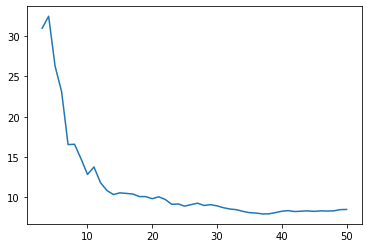

In [57]:
plt.plot(np.arange(3,51,1),rec_error.mean(axis=0))

### using simulated scenarios

In [58]:
# init result variables for storage
PCA_accuracy_store = pd.DataFrame(index = range(1000), columns = [12,24,36,60,84,120,180,240,300,348])
PCA_cumPnL_store = pd.DataFrame(index = range(1000), columns = [12,24,36,60,84,120,180,240,300,348])
PCA_dailyStd_store = pd.DataFrame(index = range(1000), columns = [12,24,36,60,84,120,180,240,300,348])
LLE_accuracy_store = pd.DataFrame(index = range(1000), columns = [12,24,36,60,84,120,180,240,300,348])
LLE_cumPnL_store = pd.DataFrame(index = range(1000), columns = [12,24,36,60,84,120,180,240,300,348])
LLE_dailyStd_store = pd.DataFrame(index = range(1000), columns = [12,24,36,60,84,120,180,240,300,348])

In [59]:
for i in range(num_paths):
    # fetch one simulated scenario
    input_curve = pd.DataFrame(SwapSpd_simu[i], index = SwapSpd_zero.index, columns = SwapSpd_zero.columns)
    # run two forecasting engines
    res_PCA, PnL_PCA, _ = Backtesting_PCA(input_curve, rolling_window=60)
    res_LLE, PnL_LLE, _ = Backtesting_LLE(input_curve, rolling_window=60, num_neighbors=37)
    # store results
    PCA_accuracy_store.loc[i] = list(res_PCA.values())
    PCA_cumPnL_store.loc[i] = PnL_PCA.cumsum().iloc[-1]
    PCA_dailyStd_store.loc[i] = PnL_PCA.std()
    LLE_accuracy_store.loc[i] = list(res_LLE.values())
    LLE_cumPnL_store.loc[i] = PnL_LLE.cumsum().iloc[-1]
    LLE_dailyStd_store.loc[i] = PnL_LLE.std()
    if i % 10 == 0:
        print(i)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990


In [60]:
PCA_accuracy_store.to_csv('data\PCA_accuracy_store.csv')

In [61]:
PCA_cumPnL_store.to_csv('data\PCA_cumPnL_store.csv')

In [62]:
PCA_dailyStd_store.to_csv('data\PCA_dailyStd_store.csv')

In [63]:
LLE_accuracy_store.to_csv('data\LLE_accuracy_store.csv')
LLE_cumPnL_store.to_csv('data\LLE_cumPnL_store.csv')
LLE_dailyStd_store.to_csv('data\LLE_dailyStd_store.csv')

read our computed metric

In [12]:
PCA_accuracy_store = pd.read_csv('data\PCA_accuracy_store.csv', index_col=0)
PCA_cumPnL_store = pd.read_csv('data\PCA_cumPnL_store.csv', index_col=0)
PCA_dailyStd_store = pd.read_csv('data\PCA_dailyStd_store.csv', index_col=0)
LLE_accuracy_store = pd.read_csv('data\LLE_accuracy_store.csv', index_col=0)
LLE_cumPnL_store = pd.read_csv('data\LLE_cumPnL_store.csv', index_col=0)
LLE_dailyStd_store = pd.read_csv('data\LLE_dailyStd_store.csv', index_col=0)

In [13]:
print(PCA_accuracy_store.mean(), '\n', LLE_accuracy_store.mean())

12     0.568447
24     0.603794
36     0.610039
60     0.613025
84     0.612373
120    0.625514
180    0.626735
240    0.614162
300    0.602062
348    0.599718
dtype: float64 
 12     0.572521
24     0.604376
36     0.612409
60     0.616960
84     0.616363
120    0.627304
180    0.624796
240    0.611466
300    0.600068
348    0.597979
dtype: float64


In [5]:
print(PCA_cumPnL_store.mean(), '\n', LLE_cumPnL_store.mean())

12     2.959962
24     2.086769
36     0.150701
60     0.559192
84     0.605031
120   -2.469241
180   -7.319863
240   -6.937584
300   -6.011375
348   -5.726191
dtype: float64 
 12     3.947042
24     2.191227
36     0.710139
60     1.110724
84     1.031178
120   -2.169738
180   -7.295804
240   -7.353928
300   -6.560260
348   -6.208722
dtype: float64


In [7]:
print(PCA_dailyStd_store.mean(), '\n', LLE_dailyStd_store.mean())

12     2.163124
24     2.162439
36     2.162624
60     2.162616
84     2.162588
120    2.162691
180    2.162773
240    2.162587
300    2.162216
348    2.162499
dtype: float64 
 12     2.162417
24     2.162219
36     2.162394
60     2.162720
84     2.162698
120    2.162736
180    2.162573
240    2.162426
300    2.162357
348    2.162619
dtype: float64


### Relative-value Trading Strategies (level, fly, butterfly)

In [5]:
def Backtesting_PCA_RV(curve_data, rolling_window=60, N=100, swap_rate=1.00, T=260, fly_tenor = [24,120], bf_tenor = [24,60,120]):
    
    accry = {'level': 0, 'fly': 0, 'bf': 0}
    PnL = pd.DataFrame(columns=list(accry.keys()), index = curve_data[rolling_window+1:].index)
    all_tenor = sorted(list(set(fly_tenor+bf_tenor)))
    prices = pd.DataFrame(columns=all_tenor, index = curve_data[rolling_window:].index)
    T_rmn = T
    
    # calculate init price
    for m in all_tenor:
        # the fixed-leg value is
        fix_val = np.sum(0.5*swap_rate/100*N* \
                  np.exp(- OIS_zero.loc[curve_data[rolling_window:rolling_window+1].index].values[0,2:21:2]/100 * curve_data[rolling_window:rolling_window+1].columns[2:21:2] / 12))+ \
                  N*np.exp(- OIS_zero.loc[curve_data[rolling_window:rolling_window+1].index].values[0,20]/100 * curve_data[rolling_window:rolling_window+1].columns[20] / 12)
        # the float-leg value is
        float_val = (1+0.5*curve_data[rolling_window:rolling_window+1][m].values[0]/100)*N* \
                    np.exp(- OIS_zero.loc[curve_data[rolling_window:rolling_window+1].index].values[0,2]/100 * curve_data[rolling_window:rolling_window+1].columns[2] / 12)
        
        prices.loc[curve_data[rolling_window:rolling_window+1].index, m] = float_val-fix_val
 
    
    for i in range( rolling_window, curve_data.shape[0]-1):
        
        # curve_data[i].index is the time to make decision, curve_data[i+1] is the time to materialize PnL
        # the first i = rolling_window
        
        train_data = curve_data[i-rolling_window:i+1]
        test_data = curve_data[i+1:i+2]
    
        scaler = StandardScaler()
        scaler.fit(train_data)
        train_data_scaled = scaler.transform(train_data)
    
        model1 = PCA(n_components=3, copy=True, whiten=False)
        model1.fit(train_data_scaled)
        train_data_low = pd.DataFrame(model1.transform(train_data_scaled))
        train_data_low.index = train_data.index
    
    
        pred_lst = []
        for col in train_data_low.columns:
            ARMA11 = smss.SARIMAX( train_data_low[col], order=(1,0,1) )
            res_fit = ARMA11.fit(disp=0,method='lbfgs')
            pred_lst.append(res_fit.forecast(1).values[0])
            
        pred_ary = np.array(pred_lst).reshape(1,-1)
        pred_data = model1.inverse_transform(pred_ary)
        pred_data = scaler.inverse_transform(pred_data)
        
        
        T_rmn -= 1 # one more less remaining week time to maturity
        # evaluate
        for m in all_tenor:
            
            # if underlying float-rate is m-month:
            # match the best approximate discount factor and coupon payment date
            num_rmn_payment = int(np.ceil(T_rmn/(4.3333*6)))
            max_payment_month = int(np.ceil(T_rmn/(4.3333*3)))
            payment_wks = np.arange(T_rmn-26*(num_rmn_payment-1), T_rmn+1, 26)
            
            assert num_rmn_payment==payment_wks.size
            
            # the fixed-leg value is
            fix_val = np.sum(0.5*swap_rate/100*N* \
                      np.exp(- OIS_zero.loc[test_data.index].values[0,max_payment_month-2*num_rmn_payment+2:max_payment_month+1:2]/100 * payment_wks / 52))+ \
                      N*np.exp(- OIS_zero.loc[test_data.index].values[0,max_payment_month]/100 * payment_wks[-1] / 52)
            # the float-leg value is
            float_val = (1+0.5*test_data[m].values[0]/100)*N* \
                        np.exp(- OIS_zero.loc[test_data.index].values[0,max_payment_month-2*num_rmn_payment+2]/100 * payment_wks[0] / 52)
         
            # update new swap price
            prices.loc[test_data.index, m] = float_val-fix_val

    
        # accuracy eval
        # level
        if (test_data[all_tenor].mean(axis=1).values - train_data[-1:][all_tenor].mean(axis=1).values) * \
            (np.mean(pred_data[0,[int(ele/12) for ele in all_tenor]]) - train_data[-1:][all_tenor].mean(axis=1).values) >= 0:
            accry['level'] += 1
        # fly
        if ((test_data[fly_tenor[1]].values-test_data[fly_tenor[0]].values) - (train_data[-1:][fly_tenor[1]].values-train_data[-1:][fly_tenor[0]].values)) * \
            ((pred_data[0,int(fly_tenor[1]/12)]-pred_data[0,int(fly_tenor[0]/12)]) - (train_data[-1:][fly_tenor[1]].values-train_data[-1:][fly_tenor[0]].values)) >= 0:
            accry['fly'] += 1
        # butterfly
        if ((test_data[bf_tenor[2]].values+test_data[bf_tenor[0]].values-2*test_data[bf_tenor[1]].values) - (train_data[-1:][bf_tenor[2]].values+train_data[-1:][bf_tenor[0]].values-2*train_data[-1:][bf_tenor[1]].values)) * \
            ((pred_data[0,int(bf_tenor[2]/12)]+pred_data[0,int(bf_tenor[0]/12)]-2*pred_data[0,int(bf_tenor[1]/12)]) - (train_data[-1:][bf_tenor[2]].values+train_data[-1:][bf_tenor[0]].values-2*train_data[-1:][bf_tenor[1]].values)) >= 0:
            accry['bf'] += 1
    
        # PnL calculation
        prices_changes = prices.diff()
        # level
        if (np.mean(pred_data[0,[int(ele/12) for ele in all_tenor]]) - train_data[-1:][all_tenor].mean(axis=1).values) >= 0:
            PnL.loc[test_data.index, 'level'] = prices_changes.loc[test_data.index].mean(axis=1)
        else:
            PnL.loc[test_data.index, 'level'] = - prices_changes.loc[test_data.index].mean(axis=1)
        # fly
        if ((pred_data[0,int(fly_tenor[1]/12)]-pred_data[0,int(fly_tenor[0]/12)]) - (train_data[-1:][fly_tenor[1]].values-train_data[-1:][fly_tenor[0]].values)) >= 0:
            PnL.loc[test_data.index, 'fly'] = prices_changes.loc[test_data.index, fly_tenor[1]] - prices_changes.loc[test_data.index, fly_tenor[0]]
        else:
            PnL.loc[test_data.index, 'fly'] = -prices_changes.loc[test_data.index, fly_tenor[1]]+prices_changes.loc[test_data.index, fly_tenor[0]]
        # butterfly
        if ((pred_data[0,int(bf_tenor[2]/12)]+pred_data[0,int(bf_tenor[0]/12)]-2*pred_data[0,int(bf_tenor[1]/12)]) - (train_data[-1:][bf_tenor[2]].values+train_data[-1:][bf_tenor[0]].values-2*train_data[-1:][bf_tenor[1]].values)) >= 0:
            PnL.loc[test_data.index, 'bf'] = 0.5*(prices_changes.loc[test_data.index, bf_tenor[0]]+prices_changes.loc[test_data.index, bf_tenor[2]]) - prices_changes.loc[test_data.index, bf_tenor[1]]
        else:
            PnL.loc[test_data.index, 'bf'] = -0.5*(prices_changes.loc[test_data.index, bf_tenor[0]]+prices_changes.loc[test_data.index, bf_tenor[2]])+prices_changes.loc[test_data.index, bf_tenor[1]]
        
    
    accry = {key: round(value / (curve_data.shape[0]-1 - rolling_window),3) for key, value in accry.items()}

    
    return accry, PnL
        


In [6]:
def Backtesting_LLE_RV(curve_data, rolling_window=60, num_neighbors = 37, N=100, swap_rate=1.00, T=260, fly_tenor = [24,120], bf_tenor = [24,60,120]):
    
    accry = {'level': 0, 'fly': 0, 'bf': 0}
    PnL = pd.DataFrame(columns=list(accry.keys()), index = curve_data[rolling_window+1:].index)
    all_tenor = sorted(list(set(fly_tenor+bf_tenor)))
    prices = pd.DataFrame(columns=all_tenor, index = curve_data[rolling_window:].index)
    T_rmn = T
    
    # calculate init price
    for m in all_tenor:
        # the fixed-leg value is
        fix_val = np.sum(0.5*swap_rate/100*N* \
                  np.exp(- OIS_zero.loc[curve_data[rolling_window:rolling_window+1].index].values[0,2:21:2]/100 * curve_data[rolling_window:rolling_window+1].columns[2:21:2] / 12))+ \
                  N*np.exp(- OIS_zero.loc[curve_data[rolling_window:rolling_window+1].index].values[0,20]/100 * curve_data[rolling_window:rolling_window+1].columns[20] / 12)
        # the float-leg value is
        float_val = (1+0.5*curve_data[rolling_window:rolling_window+1][m].values[0]/100)*N* \
                    np.exp(- OIS_zero.loc[curve_data[rolling_window:rolling_window+1].index].values[0,2]/100 * curve_data[rolling_window:rolling_window+1].columns[2] / 12)
        
        prices.loc[curve_data[rolling_window:rolling_window+1].index, m] = float_val-fix_val
 
    
    for i in range( rolling_window, curve_data.shape[0]-1):
        
        # curve_data[i].index is the time to make decision, curve_data[i+1] is the time to materialize PnL
        # the first i = rolling_window
        train_data = curve_data[i-rolling_window:i+1]
        test_data = curve_data[i+1:i+2]
    
        scaler = StandardScaler()
        scaler.fit(train_data)
        train_data_scaled = scaler.transform(train_data)
    
        model2 = LocallyLinearEmbedding(n_components=3, n_neighbors=num_neighbors)
        model2.fit(train_data_scaled)
        train_data_low = pd.DataFrame(model2.transform(train_data_scaled))
        train_data_low.index = train_data.index
        
        
        pred_lst = []
        for col in train_data_low.columns:
            ARMA11 = smss.SARIMAX( train_data_low[col], order=(1,0,1) )
            res_fit = ARMA11.fit(disp=0,method='lbfgs')
            pred_lst.append(res_fit.forecast(1).values[0])
            
        
        
        pred_ary = np.array(pred_lst).reshape(1,-1)
        
        # inverse transform
        X = np.vstack((train_data_low.to_numpy(),pred_ary))
        
        W = barycenter_kneighbors_graph(X, n_neighbors=num_neighbors)
        pred_data = W.toarray()[-1:,:-1].dot(train_data_scaled) # (1 by n_samples-1) times (n_train_samples by high_dim)
        #print(pred_data.shape, type(pred_data))
        
        pred_data = scaler.inverse_transform(pred_data)
        
        
        T_rmn -= 1 # one more less remaining week time to maturity
        # evaluate
        for m in all_tenor:
            
            # if underlying float-rate is m-month:
            # match the best approximate discount factor and coupon payment date
            num_rmn_payment = int(np.ceil(T_rmn/(4.3333*6)))
            max_payment_month = int(np.ceil(T_rmn/(4.3333*3)))
            payment_wks = np.arange(T_rmn-26*(num_rmn_payment-1), T_rmn+1, 26)
            
            assert num_rmn_payment==payment_wks.size
            
            # the fixed-leg value is
            fix_val = np.sum(0.5*swap_rate/100*N* \
                      np.exp(- OIS_zero.loc[test_data.index].values[0,max_payment_month-2*num_rmn_payment+2:max_payment_month+1:2]/100 * payment_wks / 52))+ \
                      N*np.exp(- OIS_zero.loc[test_data.index].values[0,max_payment_month]/100 * payment_wks[-1] / 52)
            # the float-leg value is
            float_val = (1+0.5*test_data[m].values[0]/100)*N* \
                        np.exp(- OIS_zero.loc[test_data.index].values[0,max_payment_month-2*num_rmn_payment+2]/100 * payment_wks[0] / 52)
         
            # update new swap price
            prices.loc[test_data.index, m] = float_val-fix_val

    
        # accuracy eval
        # level
        if (test_data[all_tenor].mean(axis=1).values - train_data[-1:][all_tenor].mean(axis=1).values) * \
            (np.mean(pred_data[0,[int(ele/12) for ele in all_tenor]]) - train_data[-1:][all_tenor].mean(axis=1).values) >= 0:
            accry['level'] += 1
        # fly
        if ((test_data[fly_tenor[1]].values-test_data[fly_tenor[0]].values) - (train_data[-1:][fly_tenor[1]].values-train_data[-1:][fly_tenor[0]].values)) * \
            ((pred_data[0,int(fly_tenor[1]/12)]-pred_data[0,int(fly_tenor[0]/12)]) - (train_data[-1:][fly_tenor[1]].values-train_data[-1:][fly_tenor[0]].values)) >= 0:
            accry['fly'] += 1
        # butterfly
        if ((test_data[bf_tenor[2]].values+test_data[bf_tenor[0]].values-2*test_data[bf_tenor[1]].values) - (train_data[-1:][bf_tenor[2]].values+train_data[-1:][bf_tenor[0]].values-2*train_data[-1:][bf_tenor[1]].values)) * \
            ((pred_data[0,int(bf_tenor[2]/12)]+pred_data[0,int(bf_tenor[0]/12)]-2*pred_data[0,int(bf_tenor[1]/12)]) - (train_data[-1:][bf_tenor[2]].values+train_data[-1:][bf_tenor[0]].values-2*train_data[-1:][bf_tenor[1]].values)) >= 0:
            accry['bf'] += 1
    
        # PnL calculation
        prices_changes = prices.diff()
        # level
        if (np.mean(pred_data[0,[int(ele/12) for ele in all_tenor]]) - train_data[-1:][all_tenor].mean(axis=1).values) >= 0:
            PnL.loc[test_data.index, 'level'] = prices_changes.loc[test_data.index].mean(axis=1)
        else:
            PnL.loc[test_data.index, 'level'] = - prices_changes.loc[test_data.index].mean(axis=1)
        # fly
        if ((pred_data[0,int(fly_tenor[1]/12)]-pred_data[0,int(fly_tenor[0]/12)]) - (train_data[-1:][fly_tenor[1]].values-train_data[-1:][fly_tenor[0]].values)) >= 0:
            PnL.loc[test_data.index, 'fly'] = prices_changes.loc[test_data.index, fly_tenor[1]] - prices_changes.loc[test_data.index, fly_tenor[0]]
        else:
            PnL.loc[test_data.index, 'fly'] = -prices_changes.loc[test_data.index, fly_tenor[1]]+prices_changes.loc[test_data.index, fly_tenor[0]]
        # butterfly
        if ((pred_data[0,int(bf_tenor[2]/12)]+pred_data[0,int(bf_tenor[0]/12)]-2*pred_data[0,int(bf_tenor[1]/12)]) - (train_data[-1:][bf_tenor[2]].values+train_data[-1:][bf_tenor[0]].values-2*train_data[-1:][bf_tenor[1]].values)) >= 0:
            PnL.loc[test_data.index, 'bf'] = 0.5*(prices_changes.loc[test_data.index, bf_tenor[0]]+prices_changes.loc[test_data.index, bf_tenor[2]]) - prices_changes.loc[test_data.index, bf_tenor[1]]
        else:
            PnL.loc[test_data.index, 'bf'] = -0.5*(prices_changes.loc[test_data.index, bf_tenor[0]]+prices_changes.loc[test_data.index, bf_tenor[2]])+prices_changes.loc[test_data.index, bf_tenor[1]]
        
    
    accry = {key: round(value / (curve_data.shape[0]-1 - rolling_window),3) for key, value in accry.items()}

    
    return accry, PnL
        

In [53]:
# init result variables for storage
PCA_accuracy_store_RV = pd.DataFrame(index = range(1000), columns = ['level','fly','bf'])
PCA_cumPnL_store_RV = pd.DataFrame(index = range(1000), columns = ['level','fly','bf'])
PCA_dailyStd_store_RV = pd.DataFrame(index = range(1000), columns = ['level','fly','bf'])
LLE_accuracy_store_RV = pd.DataFrame(index = range(1000), columns = ['level','fly','bf'])
LLE_cumPnL_store_RV = pd.DataFrame(index = range(1000), columns = ['level','fly','bf'])
LLE_dailyStd_store_RV = pd.DataFrame(index = range(1000), columns = ['level','fly','bf'])

In [54]:
for i in range(num_paths):
    # fetch one simulated scenario
    input_curve = pd.DataFrame(SwapSpd_simu[i], index = SwapSpd_zero.index, columns = SwapSpd_zero.columns)
    # run two forecasting engines
    res_PCA, PnL_PCA = Backtesting_PCA_RV(input_curve, rolling_window=60)
    res_LLE, PnL_LLE = Backtesting_LLE_RV(input_curve, rolling_window=60, num_neighbors=37)
    # store results
    PCA_accuracy_store_RV.loc[i] = list(res_PCA.values())
    PCA_cumPnL_store_RV.loc[i] = PnL_PCA.cumsum().iloc[-1]
    PCA_dailyStd_store_RV.loc[i] = PnL_PCA.std()
    LLE_accuracy_store_RV.loc[i] = list(res_LLE.values())
    LLE_cumPnL_store_RV.loc[i] = PnL_LLE.cumsum().iloc[-1]
    LLE_dailyStd_store_RV.loc[i] = PnL_LLE.std()
    if i % 10 == 0:
        print(i)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990


In [55]:
PCA_accuracy_store_RV.to_csv('data\PCA_accuracy_store_RV.csv')
PCA_cumPnL_store_RV.to_csv('data\PCA_cumPnL_store_RV.csv')
PCA_dailyStd_store_RV.to_csv('data\PCA_dailyStd_store_RV.csv')

In [56]:
LLE_accuracy_store_RV.to_csv('data\LLE_accuracy_store_RV.csv')
LLE_cumPnL_store_RV.to_csv('data\LLE_cumPnL_store_RV.csv')
LLE_dailyStd_store_RV.to_csv('data\LLE_dailyStd_store_RV.csv')

read our computed metric

In [7]:
PCA_accuracy_store_RV = pd.read_csv('data\PCA_accuracy_store_RV.csv', index_col=0)
PCA_cumPnL_store_RV = pd.read_csv('data\PCA_cumPnL_store_RV.csv', index_col=0)
PCA_dailyStd_store_RV = pd.read_csv('data\PCA_dailyStd_store_RV.csv', index_col=0)
LLE_accuracy_store_RV = pd.read_csv('data\LLE_accuracy_store_RV.csv', index_col=0)
LLE_cumPnL_store_RV = pd.read_csv('data\LLE_cumPnL_store_RV.csv', index_col=0)
LLE_dailyStd_store_RV = pd.read_csv('data\LLE_dailyStd_store_RV.csv', index_col=0)

In [10]:
print(PCA_accuracy_store_RV.mean(), '\n', LLE_accuracy_store_RV.mean())

level    0.617417
fly      0.578724
bf       0.463981
dtype: float64 
 level    0.619349
fly      0.584977
bf       0.475012
dtype: float64


In [12]:
print(PCA_cumPnL_store_RV.mean(), '\n', LLE_cumPnL_store_RV.mean())

level    0.264209
fly      0.082407
bf      -0.002209
dtype: float64 
 level    0.384348
fly      0.084692
bf      -0.000581
dtype: float64


In [13]:
print(PCA_dailyStd_store_RV.mean(), '\n', LLE_dailyStd_store_RV.mean())

level    2.162662
fly      0.009666
bf       0.001009
dtype: float64 
 level    2.162671
fly      0.009665
bf       0.001009
dtype: float64
